# Kaggle Titanic Challenge

Here is a link to the dataset: https://www.kaggle.com/c/titanic.

## Goal
Apply machine learning to predict which passengers survived the Titanic sinking. 

**My goal is to submit a trained model and try to go up the leaderboard.** 

## Overview
**training set: train.csv**

*Shape*: (891, 12)

**testing set: test.csv**

*Shape*: (418, 11)

In [ ]:
%matplotlib inline

import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, train_test_split, KFold
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.ensemble import AdaBoostClassifier, VotingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.utils import shuffle
from sklearn.preprocessing import scale
params = {
    'axes.labelsize': 'large',
    'xtick.labelsize': 'x-large',
    'legend.fontsize': 20,
    'figure.dpi': 150,
    'figure.figsize': [25,7]
}
plt.rcParams.update(params)

In [ ]:
train = pd.read_csv('./train.csv')
test = pd.read_csv('./test.csv')
train.head(3)

In [ ]:
train.describe()

In [ ]:
train.dtypes

## Data Cleaning

First, I will impute the missing values. Then, proceed to pre-processing the data and feature engineering.

--- 

*Survived* is the label I want to predict. 0 means the passenger died, while 1 means they lived.

*PassengerId* will not be used in training, and so can be dropped.

### Imputing the Missing Values - Training

In [ ]:
n_missing = train.isnull().sum().sort_values(ascending=False)
percent_missing = train.isnull().sum().sort_values(ascending=False) / len(train)
missing_train = pd.DataFrame(data=[n_missing, percent_missing])
missing_train

About 19% of the training data is missing *Age*. About 77% is missing *Cabin*, and 2 observations are missing *Embarked*.

#### Imputing Embarked

In [ ]:
train[train['Embarked'].isnull()]

Impute these two observations with the mode of Embarked. 

In [ ]:
train.Embarked.fillna('C', inplace=True)

#### Imputing Cabin

Since ~77% of the features are missing, one may consider dropping it. But, having no data on *Cabin* can represent the passenger's low socio-economic status, which may be a factor towards their survival. As such, it is better to impute them.

The observations missing *Cabin* will be imputed with 'N'.
All others will be imputed with the first letter of the *Cabin* variable. 

In [ ]:
train.Cabin.fillna('N', inplace=True)

In [ ]:
train.Cabin.unique()

In [ ]:
train.Cabin = [i[0] for i in train.Cabin]

In [ ]:
train.Cabin.value_counts()

#### Imputing Age

About 20% of the training observations are missing *Age*. To impute these, I will use Linear Regression to predict these missing values. 

However, this will be done once I engineer more features.

### Imputing the Missing Values - Testing

In [ ]:
n_missing = test.isnull().sum().sort_values(ascending=False)
percent_missing = test.isnull().sum().sort_values(ascending=False) / len(train)
missing_test = pd.DataFrame(data=[n_missing, percent_missing])
missing_test

86 of the testing data is missing *Age*. About 36% is missing *Cabin*, and 1 observation is missing *Fare*.

#### Imputing Fare

In [ ]:
test[test['Fare'].isnull()]

Impute this observation with the mean of passengers who are 'male', *Pclass* of '3', and *Embarked* from 'S'. 

In [ ]:
miss_val = test.loc[(test.Sex == 'male') & (test.Pclass == 3) & (test.Embarked == 'S')].Fare.mean()
test.Fare.fillna(miss_val, inplace=True)

#### Imputing Cabin

Perform the same imputation done to the training set to be consistent.

In [ ]:
test.Cabin.fillna('N', inplace=True)

In [ ]:
test.Cabin.unique()

In [ ]:
test.Cabin = [i[0] for i in test.Cabin]

In [ ]:
test.Cabin.value_counts()

In the training set, there is a *Cabin* with the label 'T'. When this is one-hot encoded, I will drop this column from the training set. Keeping it can cause some complications for training the model. 

If the model is trained on features that do not exist in the testing set, then the model can overfit the training set, and cannot generalize to new data. The model will have more variance and less bias.

#### Imputing Age

86 of the testing observations are missing *Age*. To impute these, I will use Linear Regression to predict these missing values. 

However, this will be done once I engineer more features.

### Feature Extraction

*Name* - Extract the title of each passenger. A passenger's title can have an effect on whether or not they survived. For instance, those with the title of *Master* may have been given priority to get on a life boat.

*SibSp* and *Parch* - Can create new features called *NumFamily*. So, for each passenger, the values of *SibSp* and *Parch* will be added + 1 (representing the passenger him/herself). 

*Ticket* - More analysis needs to be done for this feature. 

#### Extracting Title from Name

In [ ]:
def get_title(i):
    title = i.split(', ')[1].split('.')[0]
    return title

In [ ]:
train['Title'] = train.Name.apply(get_title)
test['Title'] = test.Name.apply(get_title)

In [ ]:
title_dict = {
    'Mr': 'Mr',
    'Miss': 'Miss',
    'Ms': 'Miss',
    'Mrs': 'Mrs',
    'Master': 'Master',
    'Dr': 'Dr',
    'Rev': 'Rev',
    'Col': 'Officer',
    'Mlle': 'Miss',
    'Major': 'Officer',
    'the Countess': 'Royal',
    'Sir': 'Royal',
    'Capt': 'Officer',
    'Don': 'Royal',
    'Mme': 'Royal',
    'Jonkheer': 'Royal',
    'Lady': 'Royal',
    'Dona': 'Royal'
}

train.Title = train.Title.map(title_dict)
train.drop('Name', axis=1, inplace=True)
test.Title = test.Title.map(title_dict)
test.drop('Name', axis=1, inplace=True)

In [ ]:
train.Title.value_counts()

In [ ]:
test.Title.value_counts()

#### Engineering NumFamily

In [ ]:
train['NumFamily'] = train.SibSp + train.Parch + 1
test['NumFamily'] = test.SibSp + test.Parch + 1

#### Analyzing Ticket

In [ ]:
train.Ticket.value_counts()

Looking at the unique values, there does not seem to be any reasonable way to distinguish/ clear up the data. There are lots of different levels for *Ticket*, and there is no clear way of pre-processing it. 

One may argue that *Ticket* can represent the socio-economic status of a passenger, which can influence survival. However, this can already be explained by the *Fare*, which is a much more interpretable way of determining the socio-economic status of a passenger.

So, I will drop *Ticket* from both datasets.

In [ ]:
train.drop('Ticket', axis=1, inplace=True)
test.drop('Ticket', axis=1, inplace=True)

### Pre-processing

*Pclass* - This is an integer, but is really describing is the social class the passenger belongs in (1st, 2nd, 3rd). One-Hot Encode for each social class level.

*Cabin*, *Embarked*, *Sex* - One-hot encode this. 

*Age* - Use Linear Regression to determine the missing *Age* values.

*PassengerId* - Drop this, since we won't need this in training. 

---

After imputing *Age*, drop *Cabin_T* from the training set. 

In [ ]:
train.drop('PassengerId', axis=1, inplace=True)

In [ ]:
train = pd.get_dummies(train, columns=['Title','Pclass','Embarked', 'Sex', 'Cabin'])
test = pd.get_dummies(test, columns=['Title','Pclass','Embarked', 'Sex', 'Cabin'])

In [ ]:
train.drop('Cabin_T', axis=1, inplace=True)

#### Imputing Age Via Logistic Regression

In [ ]:
def impute_age(df):
    temp_test = df.loc[df.Age.isnull()]
    temp_train = df.loc[df.Age.notna()]

    temp_train_X = temp_train.loc[:, 'SibSp':]
    temp_test_X = temp_test.loc[: , 'SibSp':]
    temp_train_y = temp_train.Age
    temp_test_y = temp_test.Age

    logreg = LinearRegression().fit(temp_train_X, temp_train_y)
    preds = logreg.predict(temp_test_X)

    df.loc[df.Age.isnull(), 'Age'] = preds

In [ ]:
impute_age(train)
impute_age(test)

## Data Analysis

**After Feature Extraction and Pre-Processing...**

train - Shape: (891,31)

test - Shape: (418, 30)

### Heat-map of the correlation of Top 10 Features on Survived

In [ ]:
correlation_mat = train.corr(method='pearson')
corr_cols = correlation_mat.nlargest(10, 'Survived')['Survived'].index
correlation_mat = np.corrcoef(train[corr_cols].values.transpose())
f, ax = plt.subplots(figsize=(10,8))
sns.set(font_scale=1.25)
sns.heatmap(correlation_mat, square=True, annot=True, 
            yticklabels=corr_cols.values, xticklabels=corr_cols.values)
plt.show()

Being a female was correlated relatively strongly with survival. 

### Distribution of Survival on Gender

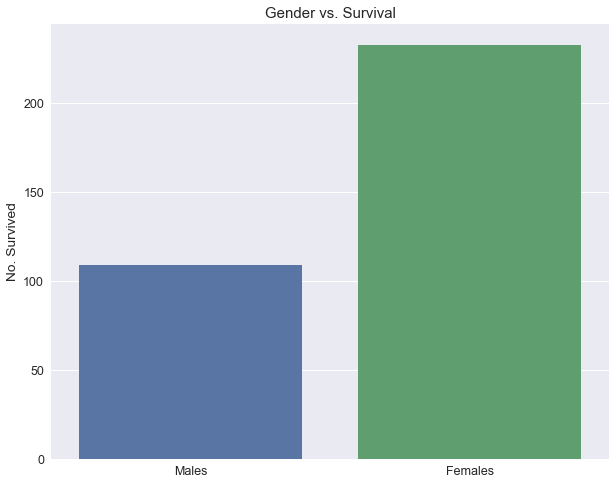

In [33]:
n_females_survived = train[(train['Sex_female'] == 1) & (train['Survived'] == 1)].Sex_female.sum()

n_males_survived = train[(train['Sex_male'] == 1) & (train['Survived'] == 1)].Sex_male.sum()

f, ax = plt.subplots(figsize=(10,8))
sns.barplot(x=['Males', 'Females'], y=[n_males_survived, n_females_survived]) 
plt.title('Gender vs. Survival')
plt.ylabel('No. Survived')
plt.show()

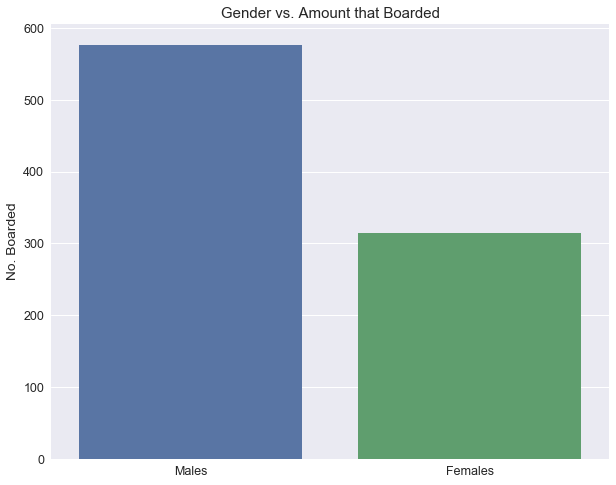

In [34]:
n_total_females = train[(train['Sex_female'] == 1)].Sex_female.sum()
n_total_males = train[(train['Sex_male'] == 1)].Sex_male.sum()

f, ax = plt.subplots(figsize=(10,8))
sns.barplot(x=['Males', 'Females'], y=[n_total_males, n_total_females]) 
plt.title('Gender vs. Amount that Boarded')
plt.ylabel('No. Boarded')
plt.show()

In [35]:
print('Percent of Males that Survived: ', n_males_survived / n_total_males)
print('Percent of Females that Survived: ', n_females_survived / n_total_females)

Percent of Males that Survived:  0.18890814558058924
Percent of Females that Survived:  0.7420382165605095


### Distribution of Survival on Pclass

In [36]:
n_firstclass_survived = train[(train['Pclass_1'] == 1) & (train['Survived'] == 1)].Pclass_1.sum()
n_secondclass_survived = train[(train['Pclass_2'] == 1) & (train['Survived'] == 1)].Pclass_2.sum()
n_thirdclass_survived = train[(train['Pclass_3'] == 1) & (train['Survived'] == 1)].Pclass_3.sum()

f, ax = plt.subplots(figsize=(10,8))
sns.barplot(x=['First Class', 'Second Class', 'Third Class'], 
            y=[n_firstclass_survived, n_secondclass_survived, n_thirdclass_survived]) 
plt.title('Passenger Class vs. Survival')
plt.ylabel('No. Survived')
plt.show()

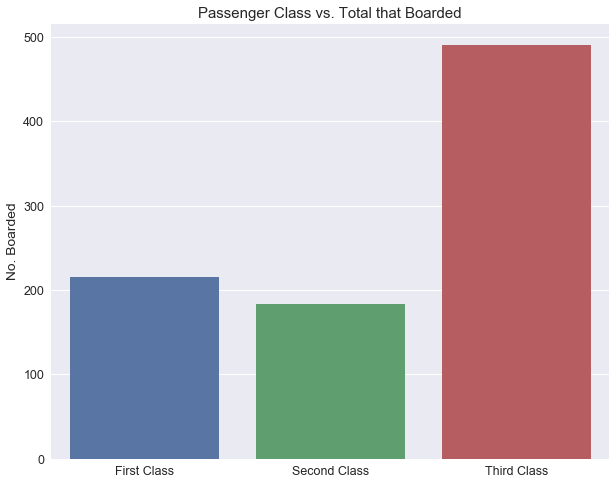

In [37]:
n_firstclass_total = train[(train['Pclass_1'] == 1)].Pclass_1.sum()
n_secondclass_total = train[(train['Pclass_2'] == 1)].Pclass_2.sum()
n_thirdclass_total = train[(train['Pclass_3'] == 1)].Pclass_3.sum()

f, ax = plt.subplots(figsize=(10,8))
sns.barplot(x=['First Class', 'Second Class', 'Third Class'], 
            y=[n_firstclass_total, n_secondclass_total, n_thirdclass_total]) 
plt.title('Passenger Class vs. Total that Boarded')
plt.ylabel('No. Boarded')
plt.show()

In [38]:
print('Percent of First Class that Survived: ', n_firstclass_survived / n_firstclass_total)
print('Percent of Second Class that Survived: ', n_secondclass_survived / n_secondclass_total)
print('Percent of Third Class that Survived: ', n_thirdclass_survived / n_thirdclass_total)

Percent of First Class that Survived:  0.6296296296296297
Percent of Second Class that Survived:  0.47282608695652173
Percent of Third Class that Survived:  0.24236252545824846


# Modeling

- **Logistic Regression**

Hyper-parameters: 

C = [0.05, 0.01, 0.5, 0.1, 1, 1.5, 2]

penalty = ['l1', 'l2']                

- **K-Nearest Neighbors**

Hyper-parameters: 

n_neighbors = [2...10]

- **Decision Tree Classifier**

Hyper-parameters:

criterion = ['entropy']

max_depth = [2...10]

min_samples_split = [2...10]

- **Support Vector Machine**

Hyper-parameters:

C_list = [0.01, 0.1, 1, 1.5, 2, 3]

- **AdaBoostClassifier**
- **Gaussian Naive Bayes**

After fitting the above, I will then use VotingClassifier, which is used for ensemble learning.

Error Metric: Accuracy

In [39]:
train.head(3)

Survived   Age  SibSp  Parch     Fare  NumFamily  Title_Dr  Title_Master  \
0         0  22.0      1      0   7.2500          2         0             0   
1         1  38.0      1      0  71.2833          2         0             0   
2         1  26.0      0      0   7.9250          1         0             0   

   Title_Miss  Title_Mr   ...     Sex_female  Sex_male  Cabin_A  Cabin_B  \
0           0         1   ...              0         1        0        0   
1           0         0   ...              1         0        0        0   
2           1         0   ...              1         0        0        0   

   Cabin_C  Cabin_D  Cabin_E  Cabin_F  Cabin_G  Cabin_N  
0        0        0        0        0        0        1  
1        1        0        0        0        0        0  
2        0        0        0        0        0        1  

[3 rows x 30 columns]

Looking at the above, *Age* and *Fare* are very different from the other variables, and from the other quantitative variables. So, I will scale them by standardizing them. 

In [40]:
train.Age = scale(train.Age)
train.Fare = scale(train.Fare)

In [41]:
test.Age = scale(test.Age)
test.Fare = scale(test.Fare)

In [42]:
train.head(3)

Survived       Age  SibSp  Parch      Fare  NumFamily  Title_Dr  \
0         0 -0.562636      1      0 -0.502445          2         0   
1         1  0.608746      1      0  0.786845          2         0   
2         1 -0.269791      0      0 -0.488854          1         0   

   Title_Master  Title_Miss  Title_Mr   ...     Sex_female  Sex_male  Cabin_A  \
0             0           0         1   ...              0         1        0   
1             0           0         0   ...              1         0        0   
2             0           1         0   ...              1         0        0   

   Cabin_B  Cabin_C  Cabin_D  Cabin_E  Cabin_F  Cabin_G  Cabin_N  
0        0        0        0        0        0        0        1  
1        0        1        0        0        0        0        0  
2        0        0        0        0        0        0        1  

[3 rows x 30 columns]

In [43]:
train = shuffle(train)
test = shuffle(test)

### Splitting Training Data

In [44]:
X = train.iloc[:, 1:]
y = train.Survived

In [45]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2)

### Logistic Regression

In [46]:
C_list = [0.05, 0.01, 0.5, 0.1, 1, 1.5, 2]
penalty_list = ['l1', 'l2']
logreg_params = {'C': C_list, 'penalty': penalty_list}

logreg = LogisticRegression()

logreg_grid = GridSearchCV(logreg, logreg_params, cv=5, scoring='accuracy')
logreg_grid.fit(X_train_val, y_train_val)

GridSearchCV(cv=5, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'C': [0.05, 0.01, 0.5, 0.1, 1, 1.5, 2], 'penalty': ['l1', 'l2']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [47]:
logreg_grid.best_score_

0.8412921348314607

In [48]:
logreg_grid.best_params_

{'C': 1.5, 'penalty': 'l1'}

In [49]:
logreg_star = logreg_grid.best_estimator_.fit(X_train_val, y_train_val)
acc = accuracy_score(logreg_star.predict(X_test), y_test)

In [50]:
print('Logistic Regression Accuracy: ', acc)

Logistic Regression Accuracy:  0.8044692737430168


### K-Nearest Neighbors

In [51]:
n_neighbors_list=np.arange(1, 11, 1)
knn_params = {'n_neighbors': n_neighbors_list}

knn_grid = KNeighborsClassifier()

knn_grid = GridSearchCV(knn_grid, knn_params, cv=5, scoring='accuracy')
knn_grid.fit(X_train_val, y_train_val)

GridSearchCV(cv=5, error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [52]:
knn_grid.best_score_

0.8117977528089888

In [53]:
knn_grid.best_params_

{'n_neighbors': 10}

In [54]:
knn_star = knn_grid.best_estimator_.fit(X_train_val, y_train_val)
acc = accuracy_score(knn_star.predict(X_test), y_test)

In [55]:
print('K-Nearest Neighbors Accuracy: ', acc)

K-Nearest Neighbors Accuracy:  0.7932960893854749


### Decision Tree Classifier

In [56]:
criterion_list = ['gini', 'entropy']
max_depth_list = np.arange(2, 11, 1)
min_samples_split_list = np.arange(2, 11, 1)

dt_params = {'criterion': criterion_list, 'max_depth': max_depth_list, 
             'min_samples_split': min_samples_split_list}

dt_grid = DecisionTreeClassifier()
dt_grid = GridSearchCV(dt_grid, dt_params, cv=5, scoring='accuracy')

dt_grid.fit(X_train_val, y_train_val)

GridSearchCV(cv=5, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'criterion': ['gini', 'entropy'], 'max_depth': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10]), 'min_samples_split': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [57]:
dt_grid.best_score_

0.8089887640449438

In [58]:
dt_grid.best_params_

{'criterion': 'entropy', 'max_depth': 4, 'min_samples_split': 3}

In [59]:
dt_star = dt_grid.best_estimator_.fit(X_train_val, y_train_val)
acc = accuracy_score(dt_star.predict(X_test), y_test)

In [60]:
print('Decision Tree Classifier Accuracy: ', acc)

Decision Tree Classifier Accuracy:  0.8100558659217877


### AdaBoostClassifier

In [61]:
adaboost_clf = AdaBoostClassifier().fit(X_train_val, y_train_val)

In [62]:
acc = accuracy_score(adaboost_clf.predict(X_test), y_test)

In [63]:
print('AdaBoostClassifier Accuracy: ', acc)

AdaBoostClassifier Accuracy:  0.7877094972067039


### Gaussian Naive Bayes

In [64]:
val_accs=[]
kfold = KFold(n_splits=5)

for train_i, val_i in kfold.split(X_train_val):
    X_train, X_val = X_train_val.iloc[train_i], X_train_val.iloc[val_i]
    y_train, y_val = y_train_val.iloc[train_i], y_train_val.iloc[val_i]
    
    gnb = GaussianNB().fit(X_train, y_train)
    
    val_accs.append(accuracy_score(gnb.predict(X_val), y_val))

In [65]:
gnb = GaussianNB().fit(X_train_val, y_train_val)
acc = accuracy_score(gnb.predict(X_test), y_test)

print('GaussianNB Accuracy: ', acc)

GaussianNB Accuracy:  0.7988826815642458


### SVM

In [66]:
C_list = [0.01, 0.1, 1, 1.5, 2, 3]
svc_params={'C': C_list}

svc = SVC(probability=True)

svc = GridSearchCV(svc, svc_params, cv=5, scoring='accuracy')
svc.fit(X_train_val, y_train_val)

GridSearchCV(cv=5, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'C': [0.01, 0.1, 1, 1.5, 2, 3]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [67]:
svc.best_score_

0.8384831460674157

In [68]:
svc.best_params_

{'C': 1}

In [69]:
svc_star = svc.best_estimator_.fit(X_train_val, y_train_val)
acc = accuracy_score(svc_star.predict(X_test), y_test)

In [70]:
print('SVM Accuracy: ', acc)

SVM Accuracy:  0.8100558659217877


### VotingClassifier

In [71]:
voting_clf = VotingClassifier(
    estimators=[
        ('logreg', logreg_grid.best_estimator_),
        ('knn', knn_grid.best_estimator_),
        ('dt', dt_grid.best_estimator_),
        ('adaboost', AdaBoostClassifier()),
        ('gnb', GaussianNB()),
        ('svc', svc.best_estimator_)
    ], voting='soft').fit(X_train_val, y_train_val)

In [72]:
acc = accuracy_score(voting_clf.predict(X_test), y_test)
print('VotingClassifier Accuracy: ', acc)

VotingClassifier Accuracy:  0.8156424581005587


D:\Coding\Jupyter\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


# Submitting Test Predictions

In [73]:
passengerId = test.PassengerId
test.drop('PassengerId', axis=1, inplace=True)
submission = pd.DataFrame({
    'PassengerId': passengerId,
    'Survived': voting_clf.predict(test)
})

D:\Coding\Jupyter\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [74]:
submission.to_csv('submissions.csv')